# 🌍🛰️ Planet: Understanding the Amazon from Space
## Use satellite data to track the human footprint in the Amazon rainforest

### Description
🌍🛰️ Planet Aerial Imagery

Every passing minute, an expanse of forest equivalent to 48 football fields disappears from our planet. The Amazon Basin takes the lead in this alarming deforestation trend, contributing to biodiversity loss, habitat destruction, climate change, and other catastrophic effects. Precise data on deforestation and human activities in forests is crucial for swift and effective responses from governments and local stakeholders.

🛰️ Planet, the innovator behind the world’s largest fleet of Earth-imaging satellites, is set to capture daily imagery of the entire Earth's land surface at an impressive 3-5 meter resolution. While existing research focuses on monitoring forest changes, it often relies on coarse-resolution imagery from sources like Landsat (30-meter pixels) or MODIS (250-meter pixels), limiting its effectiveness in areas dominated by small-scale deforestation or forest degradation.

Moreover, current methods struggle to distinguish between human-induced and natural forest loss. Higher resolution imagery, such as that from Planet, has demonstrated exceptional capability in this regard, but robust algorithms are yet to be developed.

🌈 In this competition, Planet and its Brazilian partner SCCON invite Kagglers to colorfully label satellite image chips with atmospheric conditions and various classes of land cover/land use. The resulting algorithms will empower the global community to comprehensively understand when, where, and why deforestation occurs worldwide—and, most importantly, how to respond effectively. 🚀✨

<div style="display: flex; justify-content: center; align-items: center; height: 80vh;">
    <img src="https://storage.googleapis.com/kaggle-media/competitions/kaggle/6322/media/Amazonriverbasin_basemap.png" alt="Amazon River Basin" style="width:80%; height:70%;">
</div>


### This code snippet utilizes `os.listdir` to display the contents of the dataset directory located at "../input/planets-dataset/".


In [1]:
import os
path = "../input/planets-dataset/"
os.listdir(path)

['planet', 'test-jpg-additional']

In [2]:
import pandas as pd
df_train = pd.read_csv('/kaggle/input/planets-dataset/planet/planet/train_classes.csv')
df_train

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
...,...,...
40474,train_40474,clear primary
40475,train_40475,cloudy
40476,train_40476,agriculture clear primary
40477,train_40477,agriculture clear primary road


### The provided code visualizes the distribution of classes by counting the occurrences of each tag in a dataset and plotting a bar chart using matplotlib.


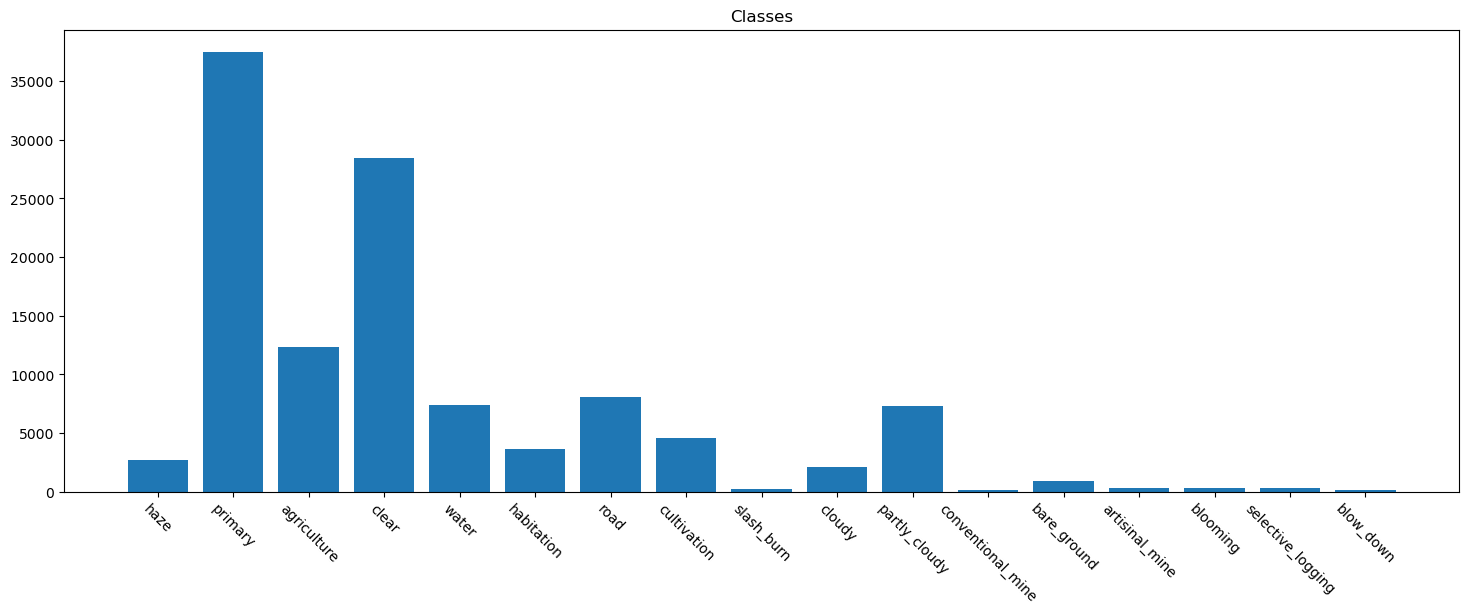

In [3]:
import matplotlib.pyplot as plt  # Make sure to import plt from matplotlib

# Total number of tags and their names.
counts = {}
splitted_tags = df_train['tags'].map(lambda x: x.split(' '))
for labels in splitted_tags.values:
    for label in labels:
        counts[label] = counts[label] + 1  if label in counts else 0

plt.figure(figsize=(18, 6))
plt.title('Classes')
idxs = range(len(counts.values()))
plt.xticks(idxs, counts.keys(), rotation=-45)
plt.bar(idxs, counts.values())
plt.show()  # Display the plot


### The provided code extracts and lists unique labels from a dataset's tags using Python, leveraging list comprehensions and set operations.


In [4]:
all_labels = splitted_tags.values
labels = list(set([y for x in all_labels for y in x]))
labels

['habitation',
 'cultivation',
 'artisinal_mine',
 'slash_burn',
 'bare_ground',
 'road',
 'cloudy',
 'water',
 'conventional_mine',
 'selective_logging',
 'blow_down',
 'primary',
 'agriculture',
 'partly_cloudy',
 'haze',
 'clear',
 'blooming']

### The provided code displays a set of five random images from the dataset along with their respective labels, utilizing matplotlib and OpenCV for visualization.


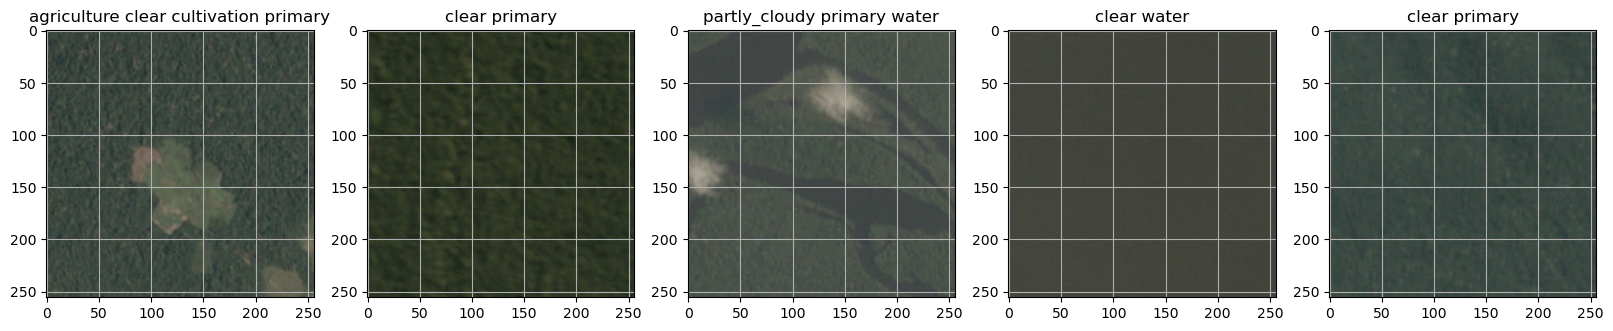

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Let's take a look at some random images.
plt.rc('axes', grid=True)

_, ax = plt.subplots(1, 5, figsize=(20, 20))
random_img = np.random.randint(0, len(df_train) - 5)

for i, row in enumerate(df_train[random_img:random_img + 5].values):
    file, label = row[:2]  # Assuming the file and label are the first two values in each row
    img = cv2.imread('/kaggle/input/planets-dataset/planet/planet/train-jpg/{}.jpg'.format(file))
    ax[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[i].set_title(label)

plt.show()


### The provided code defines a custom F-beta score function for multi-label classification in TensorFlow. It calculates the F-beta score based on true positives, false positives, and false negatives, with adjustable beta and epsilon parameters to control the score's sensitivity to precision and recall. The function uses TensorFlow operations for efficient computation.


In [6]:
import tensorflow as tf

def fbeta_score(y_true, y_pred, beta=2, epsilon=1e-4):
    """
    Compute the F-beta score for multi-label classification.

    Args:
        y_true: Correct target values.
        y_pred: Predicted values returned by the classifier.
        beta: Beta value for weighting precision and recall.
        epsilon: Small constant to avoid division by zero.

    Returns:
        F-beta score.
    """
    beta_squared = beta**2

    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.greater(tf.cast(y_pred, tf.float32), 0.5), tf.float32)

    true_positive = tf.reduce_sum(y_true * y_pred, axis=1)
    false_positive = tf.reduce_sum(y_pred, axis=1) - true_positive
    false_negative = tf.reduce_sum(y_true, axis=1) - true_positive

    precision = true_positive / (true_positive + false_positive + epsilon)
    recall = true_positive / (true_positive + false_negative + epsilon)

    fbeta = (1 + beta_squared) * precision * recall / (beta_squared * precision + recall + epsilon)
    return fbeta

### The provided code defines a Convolutional Neural Network (CNN) model for image classification using TensorFlow's Keras API. The architecture consists of convolutional and pooling layers, followed by fully connected layers, and is compiled with the Adam optimizer and binary cross-entropy loss. The summary of the model's structure is displayed using the `model.summary()` function.


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.1),

    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.1),

    Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.1),

    Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.1),

    Flatten(),

    Dense(1024, activation='relu'),
    Dense(17, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[fbeta_score])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 63, 63, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 61, 64)        36928     
                                                        

### The provided code initializes a convolutional neural network (CNN) model using the ResNet50 architecture as a base


In [8]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten

optimizer = Adam(learning_rate=0.003)

base_model = ResNet50(weights=None, include_top=False, input_shape=(128, 128, 3))

for layer in base_model.layers:
    layer.trainable = True

model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(17, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[fbeta_score])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               4194432   
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 17)                2193      
                                                                 
Total params: 27,784,337
Trainable params: 27,731,217
Non-trainable params: 53,120
_________________________________________________________________


### The provided code reads a CSV file ('train_classes.csv') containing image tags, extracts unique labels, and performs one-hot encoding on the dataset. The resulting DataFrame, df_train, includes binary columns for each label. The set of unique labels is converted to a list, and the one-hot encoding is applied to the 'tags' column. The final DataFrame includes the original image information and binary labels for each unique tag.


In [9]:
train_label = pd.read_csv("/kaggle/input/planets-dataset/planet/planet/train_classes.csv")
train_label

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
...,...,...
40474,train_40474,clear primary
40475,train_40475,cloudy
40476,train_40476,agriculture clear primary
40477,train_40477,agriculture clear primary road


In [10]:
labels = set()

def extract_unique_labels(tag_string):
    '''
    Takes in a string of tags, splits the tags, and stores them in a set
    '''
    [labels.add(tag) for tag in tag_string.split()]

In [11]:
train_label = train_label.copy()
df_train['tags'].apply(extract_unique_labels)
# Convert the set of unique labels to a list
labels_list = list(labels)
print(labels_list)

['habitation', 'cultivation', 'artisinal_mine', 'slash_burn', 'bare_ground', 'road', 'cloudy', 'water', 'conventional_mine', 'selective_logging', 'blow_down', 'primary', 'agriculture', 'partly_cloudy', 'haze', 'clear', 'blooming']


In [12]:
# One hot encoding for the labels in train classes
for lab in labels_list:
    df_train[lab] = df_train['tags'].apply(lambda x: 1 if lab in x.split() else 0)
    
# Adding '.jpg' extension to the 'image_name' column for consistency with image file names
df_train['image_name'] = df_train['image_name'].apply(lambda x: f'{x}.jpg')
df_train.head()

,image_name,tags,habitation,cultivation,artisinal_mine,slash_burn,bare_ground,road,cloudy,water,conventional_mine,selective_logging,blow_down,primary,agriculture,partly_cloudy,haze,clear,blooming
0,train_0.jpg,haze primary,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
1,train_1.jpg,agriculture clear primary water,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0
2,train_2.jpg,clear primary,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,train_3.jpg,clear primary,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,train_4.jpg,agriculture clear habitation primary road,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0


In [13]:
columns = list(df_train.columns[2:])
columns

['habitation',
 'cultivation',
 'artisinal_mine',
 'slash_burn',
 'bare_ground',
 'road',
 'cloudy',
 'water',
 'conventional_mine',
 'selective_logging',
 'blow_down',
 'primary',
 'agriculture',
 'partly_cloudy',
 'haze',
 'clear',
 'blooming']

### The provided code block sets up a Model Checkpoint to save the best model based on the validation F-beta score during training. It also configures an Image Data Generator for data augmentation, creating separate generators for training and validation data. The model is then trained using the defined generators and parameters, with the best model saved using the Model Checkpoint callback.


In [14]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd

# Model Checkpoint
save_best_check_point = ModelCheckpoint(filepath='best_model.hdf5', 
                                        monitor='val_fbeta_score',
                                        mode='max',
                                        save_best_only=True,
                                        save_weights_only=False)

# Image Data Generator
train_datagen = ImageDataGenerator(rescale=1/255, validation_split=0.2)

print("Train Data Generator")
# Train Data Generator
train_generator = train_datagen.flow_from_dataframe(dataframe=df_train,
                                                    directory="/kaggle/input/planets-dataset/planet/planet/train-jpg",
                                                    x_col="image_name", y_col=columns, subset="training",
                                                    batch_size=16, seed=42, shuffle=True,
                                                    class_mode="raw", target_size=(128, 128))

# Validation Data Generator
val_generator = train_datagen.flow_from_dataframe(dataframe=df_train,
                                                  directory="/kaggle/input/planets-dataset/planet/planet/train-jpg",
                                                  x_col="image_name", y_col=columns, subset="validation",
                                                  batch_size=16, seed=42, shuffle=True,
                                                  class_mode="raw", target_size=(128, 128))

print('Fitting the model using the parameters already defined')
# Fitting the model using the parameters already defined
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[fbeta_score])

history = model.fit(
    x=train_generator,
    validation_data=val_generator,
    epochs=1,
    callbacks=[save_best_check_point]
)


Train Data Generator
Found 32384 validated image filenames.
Found 8095 validated image filenames.
Fitting the model using the parameters already defined
2024/2024 [==============================] - 311s 134ms/step - loss: 0.2819 - fbeta_score: 0.6373 - val_loss: 0.2324 - val_fbeta_score: 0.6355


In [15]:
# !rm *.csv
!ls

rm: cannot remove '*.csv': No such file or directory
best_model.hdf5


### The code block loads the sample submission file from the specified path and prints its content. It uses the Pandas library to read the CSV file containing sample submission data for the "Planet: Understanding the Amazon from Space" Kaggle competition.


In [16]:
print('Loading the sample submission file')
# Loading the sample submission file
sample_submission = pd.read_csv('/kaggle/input/planets-dataset/planet/planet/sample_submission.csv')
print(sample_submission)

Loading the sample submission file
      image_name                                  tags
0         test_0  primary clear agriculture road water
1         test_1  primary clear agriculture road water
2         test_2  primary clear agriculture road water
3         test_3  primary clear agriculture road water
4         test_4  primary clear agriculture road water
...          ...                                   ...
61186  file_9995  primary clear agriculture road water
61187  file_9996  primary clear agriculture road water
61188  file_9997  primary clear agriculture road water
61189  file_9998  primary clear agriculture road water
61190  file_9999  primary clear agriculture road water

[61191 rows x 2 columns]


### The provided code initializes a second model for predictions using a pre-trained model ('best_model.hdf5'). It then generates a CSV file for submission to Kaggle, predicting tags for test images. The resulting DataFrame is saved as 'understanding_amazon_from_space.csv'.


In [17]:
labels_list

['habitation',
 'cultivation',
 'artisinal_mine',
 'slash_burn',
 'bare_ground',
 'road',
 'cloudy',
 'water',
 'conventional_mine',
 'selective_logging',
 'blow_down',
 'primary',
 'agriculture',
 'partly_cloudy',
 'haze',
 'clear',
 'blooming']

In [18]:
print('Initializing a second model for predictions')
from tensorflow.keras.models import load_model
loaded_model = load_model('best_model.hdf5', custom_objects={'fbeta_score': fbeta_score})
loaded_model

Initializing a second model for predictions


In [19]:
!ls kaggle/input/planets-dataset/planet/planet/test-jpg

ls: cannot access 'kaggle/input/planets-dataset/planet/planet/test-jpg': No such file or directory


In [ ]:
from tqdm import tqdm
from os import listdir
import cv2
import numpy as np
import pandas as pd

# Define paths
test_images_path = "/kaggle/input/planets-dataset/planet/planet/test-jpg"
additional_test_images_path = '../input/planets-dataset/test-jpg-additional/test-jpg-additional'

# Create a list to store image paths from both directories
all_image_paths = []

# Append image paths from the first directory
all_image_paths.extend([f'{test_images_path}/{file}' for file in listdir(test_images_path)])

# Append image paths from the second directory
all_image_paths.extend([f'{additional_test_images_path}/{file}' for file in listdir(additional_test_images_path)])

# Create a DataFrame to store predictions
submission_df = pd.DataFrame(columns=['image_name', 'tags'])

# Create a tqdm progress bar with the total number of files
with tqdm(total=len(all_image_paths), desc="Processing Images") as pbar:
    for image_path in all_image_paths:
        filename = image_path.split('/')[-1].split('.')[0]

        # Check if the image name has already been processed
        if filename not in submission_df['image_name'].values:
            img = cv2.imread(image_path)
            targets = np.zeros(17)

            X_test = np.array([cv2.resize(img, (128, 128))], np.float16) / 255
            y_test = loaded_model.predict(X_test, batch_size=128)

            tags = ' '.join(np.array(labels_list)[y_test[0] > 0.2])
            submission_df = submission_df.append({'image_name': filename, 'tags': tags}, ignore_index=True)

            # Update the progress bar
            pbar.update(1)  # Increment by 1 for each iteration

# Save the DataFrame to CSV
submission_df.to_csv('predictions.csv', index=False)


Processing Images:   0%|          | 0/61191 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step


Processing Images:   0%|          | 1/61191 [00:01<21:58:22,  1.29s/it]

1/1 [==============================] - 0s 26ms/step


Processing Images:   0%|          | 3/61191 [00:01<6:42:16,  2.54it/s] 

1/1 [==============================] - 0s 26ms/step


Processing Images:   0%|          | 5/61191 [00:01<4:02:59,  4.20it/s]

1/1 [==============================] - 0s 41ms/step


Processing Images:   0%|          | 6/61191 [00:01<3:28:09,  4.90it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   0%|          | 8/61191 [00:01<2:38:31,  6.43it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   0%|          | 10/61191 [00:02<2:06:23,  8.07it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 12/61191 [00:02<1:46:52,  9.54it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 14/61191 [00:02<1:35:21, 10.69it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 16/61191 [00:02<1:27:17, 11.68it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 18/61191 [00:02<1:21:33, 12.50it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 20/61191 [00:02<1:18:53, 12.92it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 22/61191 [00:02<1:17:04, 13.23it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   0%|          | 24/61191 [00:03<1:16:21, 13.35it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 26/61191 [00:03<1:15:38, 13.48it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   0%|          | 28/61191 [00:03<1:16:22, 13.35it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 30/61191 [00:03<1:17:11, 13.20it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 32/61191 [00:03<1:15:31, 13.50it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 34/61191 [00:03<1:14:11, 13.74it/s]

1/1 [==============================] - 0s 22ms/step


Processing Images:   0%|          | 36/61191 [00:03<1:12:48, 14.00it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 38/61191 [00:04<1:12:44, 14.01it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 40/61191 [00:04<1:12:15, 14.11it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 42/61191 [00:04<1:12:02, 14.15it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   0%|          | 44/61191 [00:04<1:11:52, 14.18it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   0%|          | 46/61191 [00:04<1:13:48, 13.81it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 48/61191 [00:04<1:13:37, 13.84it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 50/61191 [00:04<1:14:57, 13.59it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 52/61191 [00:05<1:13:53, 13.79it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 54/61191 [00:05<1:12:59, 13.96it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   0%|          | 56/61191 [00:05<1:14:57, 13.59it/s]

1/1 [==============================] - 0s 22ms/step


Processing Images:   0%|          | 58/61191 [00:05<1:13:47, 13.81it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 60/61191 [00:05<1:12:24, 14.07it/s]

1/1 [==============================] - 0s 29ms/step


Processing Images:   0%|          | 62/61191 [00:05<1:14:59, 13.59it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   0%|          | 64/61191 [00:05<1:15:19, 13.53it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 66/61191 [00:06<1:14:29, 13.68it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 68/61191 [00:06<1:14:00, 13.77it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 70/61191 [00:06<1:13:42, 13.82it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   0%|          | 72/61191 [00:06<1:14:58, 13.59it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   0%|          | 74/61191 [00:06<1:16:14, 13.36it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 76/61191 [00:06<1:15:00, 13.58it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 78/61191 [00:06<1:13:47, 13.80it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 80/61191 [00:07<1:12:33, 14.04it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   0%|          | 82/61191 [00:07<1:13:06, 13.93it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   0%|          | 84/61191 [00:07<1:15:42, 13.45it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   0%|          | 86/61191 [00:07<1:14:42, 13.63it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   0%|          | 88/61191 [00:07<1:14:15, 13.71it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 90/61191 [00:07<1:13:10, 13.92it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   0%|          | 92/61191 [00:08<1:14:35, 13.65it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 94/61191 [00:08<1:16:08, 13.37it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 96/61191 [00:08<1:14:41, 13.63it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 98/61191 [00:08<1:14:18, 13.70it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 100/61191 [00:08<1:13:17, 13.89it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   0%|          | 102/61191 [00:08<1:13:56, 13.77it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 104/61191 [00:08<1:12:59, 13.95it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 106/61191 [00:09<1:12:34, 14.03it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 108/61191 [00:09<1:12:04, 14.12it/s]

1/1 [==============================] - 0s 22ms/step


Processing Images:   0%|          | 110/61191 [00:09<1:11:54, 14.16it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   0%|          | 112/61191 [00:09<1:14:26, 13.68it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   0%|          | 114/61191 [00:09<1:15:13, 13.53it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 116/61191 [00:09<1:14:00, 13.75it/s]

1/1 [==============================] - 0s 22ms/step


Processing Images:   0%|          | 118/61191 [00:09<1:12:57, 13.95it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 120/61191 [00:10<1:13:13, 13.90it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   0%|          | 122/61191 [00:10<1:13:19, 13.88it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 124/61191 [00:10<1:13:36, 13.83it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 126/61191 [00:10<1:13:11, 13.91it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 128/61191 [00:10<1:12:15, 14.09it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 130/61191 [00:10<1:14:12, 13.71it/s]

1/1 [==============================] - 0s 22ms/step


Processing Images:   0%|          | 132/61191 [00:10<1:12:43, 13.99it/s]

1/1 [==============================] - 0s 22ms/step


Processing Images:   0%|          | 134/61191 [00:11<1:13:00, 13.94it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 136/61191 [00:11<1:13:25, 13.86it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 138/61191 [00:11<1:13:00, 13.94it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   0%|          | 140/61191 [00:11<1:14:37, 13.64it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 142/61191 [00:11<1:13:43, 13.80it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 144/61191 [00:11<1:12:53, 13.96it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 146/61191 [00:11<1:13:25, 13.86it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 148/61191 [00:12<1:13:47, 13.79it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 150/61191 [00:12<1:12:27, 14.04it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   0%|          | 152/61191 [00:12<1:14:25, 13.67it/s]

1/1 [==============================] - 0s 22ms/step


Processing Images:   0%|          | 154/61191 [00:12<1:13:41, 13.80it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 156/61191 [00:12<1:12:43, 13.99it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 158/61191 [00:12<1:13:20, 13.87it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 160/61191 [00:12<1:12:06, 14.11it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 162/61191 [00:13<1:11:52, 14.15it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 164/61191 [00:13<1:11:18, 14.26it/s]

1/1 [==============================] - 0s 27ms/step


Processing Images:   0%|          | 166/61191 [00:13<1:12:42, 13.99it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   0%|          | 168/61191 [00:13<1:14:45, 13.61it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 170/61191 [00:13<1:14:15, 13.70it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 172/61191 [00:13<1:12:55, 13.94it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 174/61191 [00:13<1:12:19, 14.06it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 176/61191 [00:14<1:12:34, 14.01it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   0%|          | 178/61191 [00:14<1:12:41, 13.99it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   0%|          | 180/61191 [00:14<1:14:22, 13.67it/s]

1/1 [==============================] - 0s 27ms/step


Processing Images:   0%|          | 182/61191 [00:14<1:15:25, 13.48it/s]

1/1 [==============================] - 0s 31ms/step


Processing Images:   0%|          | 184/61191 [00:14<1:18:56, 12.88it/s]

1/1 [==============================] - 0s 29ms/step


Processing Images:   0%|          | 186/61191 [00:14<1:21:31, 12.47it/s]

1/1 [==============================] - 0s 27ms/step


Processing Images:   0%|          | 188/61191 [00:15<1:21:28, 12.48it/s]

1/1 [==============================] - 0s 28ms/step


Processing Images:   0%|          | 190/61191 [00:15<1:21:02, 12.55it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   0%|          | 192/61191 [00:15<1:22:00, 12.40it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 194/61191 [00:15<1:18:51, 12.89it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   0%|          | 196/61191 [00:15<1:17:44, 13.08it/s]

1/1 [==============================] - 0s 40ms/step


Processing Images:   0%|          | 198/61191 [00:15<1:22:21, 12.34it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   0%|          | 200/61191 [00:15<1:20:34, 12.62it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 202/61191 [00:16<1:17:29, 13.12it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   0%|          | 204/61191 [00:16<1:18:22, 12.97it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   0%|          | 206/61191 [00:16<1:16:46, 13.24it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 208/61191 [00:16<1:15:23, 13.48it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 210/61191 [00:16<1:14:01, 13.73it/s]

1/1 [==============================] - 0s 27ms/step


Processing Images:   0%|          | 212/61191 [00:16<1:15:12, 13.51it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   0%|          | 214/61191 [00:16<1:16:01, 13.37it/s]

1/1 [==============================] - 0s 49ms/step


Processing Images:   0%|          | 216/61191 [00:17<1:29:26, 11.36it/s]

1/1 [==============================] - 0s 47ms/step


Processing Images:   0%|          | 218/61191 [00:17<1:47:55,  9.42it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   0%|          | 220/61191 [00:17<1:44:48,  9.70it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 222/61191 [00:17<1:35:01, 10.69it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   0%|          | 224/61191 [00:18<1:30:04, 11.28it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   0%|          | 226/61191 [00:18<1:24:38, 12.00it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 228/61191 [00:18<1:21:20, 12.49it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   0%|          | 230/61191 [00:18<1:19:51, 12.72it/s]

1/1 [==============================] - 0s 27ms/step


Processing Images:   0%|          | 232/61191 [00:18<1:21:06, 12.53it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   0%|          | 234/61191 [00:18<1:20:37, 12.60it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   0%|          | 236/61191 [00:18<1:19:26, 12.79it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   0%|          | 238/61191 [00:19<1:18:52, 12.88it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   0%|          | 240/61191 [00:19<1:17:03, 13.18it/s]

1/1 [==============================] - 0s 28ms/step


Processing Images:   0%|          | 242/61191 [00:19<1:19:31, 12.77it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   0%|          | 244/61191 [00:19<1:19:30, 12.78it/s]

1/1 [==============================] - 0s 27ms/step


Processing Images:   0%|          | 246/61191 [00:19<1:21:10, 12.51it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   0%|          | 248/61191 [00:19<1:20:58, 12.54it/s]

1/1 [==============================] - 0s 27ms/step


Processing Images:   0%|          | 250/61191 [00:20<1:20:57, 12.55it/s]

1/1 [==============================] - 0s 27ms/step


Processing Images:   0%|          | 252/61191 [00:20<1:23:04, 12.23it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   0%|          | 254/61191 [00:20<1:21:12, 12.51it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   0%|          | 256/61191 [00:20<1:20:01, 12.69it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 258/61191 [00:20<1:19:28, 12.78it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   0%|          | 260/61191 [00:20<1:18:53, 12.87it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 262/61191 [00:20<1:16:55, 13.20it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   0%|          | 264/61191 [00:21<1:15:20, 13.48it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 266/61191 [00:21<1:14:30, 13.63it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 268/61191 [00:21<1:13:24, 13.83it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   0%|          | 270/61191 [00:21<1:13:57, 13.73it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 272/61191 [00:21<1:13:09, 13.88it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 274/61191 [00:21<1:12:31, 14.00it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 276/61191 [00:21<1:12:46, 13.95it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 278/61191 [00:22<1:11:57, 14.11it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 280/61191 [00:22<1:12:39, 13.97it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 282/61191 [00:22<1:12:32, 13.99it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 284/61191 [00:22<1:11:40, 14.16it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   0%|          | 286/61191 [00:22<1:11:50, 14.13it/s]

1/1 [==============================] - 0s 28ms/step


Processing Images:   0%|          | 288/61191 [00:22<1:14:22, 13.65it/s]

1/1 [==============================] - 0s 27ms/step


Processing Images:   0%|          | 290/61191 [00:22<1:17:06, 13.16it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   0%|          | 292/61191 [00:23<1:17:45, 13.05it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   0%|          | 294/61191 [00:23<1:17:30, 13.09it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 296/61191 [00:23<1:16:04, 13.34it/s]

1/1 [==============================] - 0s 27ms/step


Processing Images:   0%|          | 298/61191 [00:23<1:18:11, 12.98it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   0%|          | 300/61191 [00:23<1:17:13, 13.14it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 302/61191 [00:23<1:15:36, 13.42it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   0%|          | 304/61191 [00:24<1:13:39, 13.78it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 306/61191 [00:24<1:12:53, 13.92it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   1%|          | 308/61191 [00:24<1:15:12, 13.49it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|          | 310/61191 [00:24<1:14:49, 13.56it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 312/61191 [00:24<1:14:15, 13.66it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 314/61191 [00:24<1:16:12, 13.31it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 316/61191 [00:24<1:15:26, 13.45it/s]

1/1 [==============================] - 0s 27ms/step


Processing Images:   1%|          | 318/61191 [00:25<1:15:38, 13.41it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|          | 320/61191 [00:25<1:18:47, 12.88it/s]

1/1 [==============================] - 0s 27ms/step


Processing Images:   1%|          | 322/61191 [00:25<1:22:01, 12.37it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 324/61191 [00:25<1:20:23, 12.62it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|          | 326/61191 [00:25<1:20:30, 12.60it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|          | 328/61191 [00:25<1:21:22, 12.46it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|          | 330/61191 [00:26<1:19:28, 12.76it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 332/61191 [00:26<1:17:36, 13.07it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 334/61191 [00:26<1:16:56, 13.18it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 336/61191 [00:26<1:16:41, 13.22it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 338/61191 [00:26<1:15:41, 13.40it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 340/61191 [00:26<1:14:39, 13.58it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|          | 342/61191 [00:26<1:14:44, 13.57it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|          | 344/61191 [00:27<1:15:47, 13.38it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|          | 346/61191 [00:27<1:15:38, 13.41it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 348/61191 [00:27<1:16:13, 13.30it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 350/61191 [00:27<1:15:23, 13.45it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 352/61191 [00:27<1:14:44, 13.57it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|          | 354/61191 [00:27<1:15:35, 13.41it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|          | 356/61191 [00:27<1:16:57, 13.17it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 358/61191 [00:28<1:16:22, 13.28it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|          | 360/61191 [00:28<1:16:05, 13.32it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|          | 362/61191 [00:28<1:17:14, 13.13it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|          | 364/61191 [00:28<1:18:45, 12.87it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   1%|          | 366/61191 [00:28<1:18:36, 12.89it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   1%|          | 368/61191 [00:28<1:18:26, 12.92it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|          | 370/61191 [00:29<1:18:18, 12.94it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   1%|          | 372/61191 [00:29<1:19:11, 12.80it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|          | 374/61191 [00:29<1:18:58, 12.83it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|          | 376/61191 [00:29<1:18:30, 12.91it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 378/61191 [00:29<1:17:27, 13.09it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|          | 380/61191 [00:29<1:17:46, 13.03it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|          | 382/61191 [00:29<1:19:07, 12.81it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 384/61191 [00:30<1:17:36, 13.06it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 386/61191 [00:30<1:17:04, 13.15it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|          | 388/61191 [00:30<1:16:18, 13.28it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 390/61191 [00:30<1:15:22, 13.44it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 392/61191 [00:30<1:16:28, 13.25it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|          | 394/61191 [00:30<1:15:17, 13.46it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 396/61191 [00:31<1:15:08, 13.48it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 398/61191 [00:31<1:14:04, 13.68it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|          | 400/61191 [00:31<1:15:31, 13.41it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 402/61191 [00:31<1:14:47, 13.55it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 404/61191 [00:31<1:14:26, 13.61it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 406/61191 [00:31<1:13:42, 13.74it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 408/61191 [00:31<1:13:45, 13.73it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 410/61191 [00:32<1:15:51, 13.35it/s]

1/1 [==============================] - 0s 27ms/step


Processing Images:   1%|          | 412/61191 [00:32<1:18:33, 12.89it/s]

1/1 [==============================] - 0s 29ms/step


Processing Images:   1%|          | 414/61191 [00:32<1:20:57, 12.51it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|          | 416/61191 [00:32<1:23:02, 12.20it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|          | 418/61191 [00:32<1:20:41, 12.55it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   1%|          | 420/61191 [00:32<1:20:24, 12.60it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 422/61191 [00:33<1:19:22, 12.76it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 424/61191 [00:33<1:17:43, 13.03it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|          | 426/61191 [00:33<1:16:55, 13.17it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|          | 428/61191 [00:33<1:18:18, 12.93it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|          | 430/61191 [00:33<1:16:47, 13.19it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 432/61191 [00:33<1:15:54, 13.34it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 434/61191 [00:33<1:15:35, 13.40it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 436/61191 [00:34<1:14:35, 13.58it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   1%|          | 438/61191 [00:34<1:15:45, 13.36it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 440/61191 [00:34<1:15:34, 13.40it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 442/61191 [00:34<1:14:51, 13.53it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   1%|          | 444/61191 [00:34<1:15:19, 13.44it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|          | 446/61191 [00:34<1:14:43, 13.55it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 448/61191 [00:34<1:15:06, 13.48it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 450/61191 [00:35<1:15:18, 13.44it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 452/61191 [00:35<1:14:12, 13.64it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 454/61191 [00:35<1:15:14, 13.45it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 456/61191 [00:35<1:16:02, 13.31it/s]

1/1 [==============================] - 0s 27ms/step


Processing Images:   1%|          | 458/61191 [00:35<1:16:12, 13.28it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   1%|          | 460/61191 [00:35<1:18:30, 12.89it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|          | 462/61191 [00:36<1:17:29, 13.06it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 464/61191 [00:36<1:16:38, 13.20it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   1%|          | 466/61191 [00:36<1:17:44, 13.02it/s]

1/1 [==============================] - 0s 27ms/step


Processing Images:   1%|          | 468/61191 [00:36<1:20:08, 12.63it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 470/61191 [00:36<1:18:34, 12.88it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 472/61191 [00:36<1:17:17, 13.09it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 474/61191 [00:36<1:16:49, 13.17it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   1%|          | 476/61191 [00:37<1:16:48, 13.17it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 478/61191 [00:37<1:18:08, 12.95it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 480/61191 [00:37<1:18:40, 12.86it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 482/61191 [00:37<1:16:42, 13.19it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   1%|          | 484/61191 [00:37<1:17:24, 13.07it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|          | 486/61191 [00:37<1:16:46, 13.18it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|          | 488/61191 [00:38<1:17:24, 13.07it/s]

1/1 [==============================] - 0s 27ms/step


Processing Images:   1%|          | 490/61191 [00:38<1:18:39, 12.86it/s]

1/1 [==============================] - 0s 28ms/step


Processing Images:   1%|          | 492/61191 [00:38<1:19:45, 12.68it/s]

1/1 [==============================] - 0s 28ms/step


Processing Images:   1%|          | 494/61191 [00:38<1:23:14, 12.15it/s]

1/1 [==============================] - 0s 27ms/step


Processing Images:   1%|          | 496/61191 [00:38<1:22:52, 12.21it/s]

1/1 [==============================] - 0s 27ms/step


Processing Images:   1%|          | 498/61191 [00:38<1:23:04, 12.18it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   1%|          | 500/61191 [00:38<1:22:29, 12.26it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   1%|          | 502/61191 [00:39<1:22:02, 12.33it/s]

1/1 [==============================] - 0s 28ms/step


Processing Images:   1%|          | 504/61191 [00:39<1:23:24, 12.13it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|          | 506/61191 [00:39<1:21:48, 12.36it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   1%|          | 508/61191 [00:39<1:20:10, 12.61it/s]

1/1 [==============================] - 0s 29ms/step


Processing Images:   1%|          | 510/61191 [00:39<1:24:18, 12.00it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   1%|          | 512/61191 [00:39<1:26:38, 11.67it/s]

1/1 [==============================] - 0s 27ms/step


Processing Images:   1%|          | 514/61191 [00:40<1:25:05, 11.89it/s]

1/1 [==============================] - 0s 27ms/step


Processing Images:   1%|          | 516/61191 [00:40<1:24:22, 11.98it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 518/61191 [00:40<1:22:12, 12.30it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 520/61191 [00:40<1:19:36, 12.70it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 522/61191 [00:40<1:18:20, 12.91it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   1%|          | 524/61191 [00:40<1:17:33, 13.04it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 526/61191 [00:41<1:16:53, 13.15it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 528/61191 [00:41<1:15:47, 13.34it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 530/61191 [00:41<1:15:22, 13.41it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 532/61191 [00:41<1:16:17, 13.25it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 534/61191 [00:41<1:14:55, 13.49it/s]

1/1 [==============================] - 0s 27ms/step


Processing Images:   1%|          | 536/61191 [00:41<1:17:54, 12.98it/s]

1/1 [==============================] - 0s 28ms/step


Processing Images:   1%|          | 538/61191 [00:41<1:19:50, 12.66it/s]

1/1 [==============================] - 0s 29ms/step


Processing Images:   1%|          | 540/61191 [00:42<1:22:55, 12.19it/s]

1/1 [==============================] - 0s 28ms/step


Processing Images:   1%|          | 542/61191 [00:42<1:24:17, 11.99it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   1%|          | 544/61191 [00:42<1:23:22, 12.12it/s]

1/1 [==============================] - 0s 27ms/step


Processing Images:   1%|          | 546/61191 [00:42<1:22:30, 12.25it/s]

1/1 [==============================] - 0s 27ms/step


Processing Images:   1%|          | 548/61191 [00:42<1:22:09, 12.30it/s]

1/1 [==============================] - 0s 29ms/step


Processing Images:   1%|          | 550/61191 [00:42<1:23:54, 12.04it/s]

1/1 [==============================] - 0s 28ms/step


Processing Images:   1%|          | 552/61191 [00:43<1:23:53, 12.05it/s]

1/1 [==============================] - 0s 29ms/step


Processing Images:   1%|          | 554/61191 [00:43<1:24:29, 11.96it/s]

1/1 [==============================] - 0s 27ms/step


Processing Images:   1%|          | 556/61191 [00:43<1:24:04, 12.02it/s]

1/1 [==============================] - 0s 27ms/step


Processing Images:   1%|          | 558/61191 [00:43<1:25:19, 11.84it/s]

1/1 [==============================] - 0s 27ms/step


Processing Images:   1%|          | 560/61191 [00:43<1:25:43, 11.79it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   1%|          | 562/61191 [00:44<1:24:40, 11.93it/s]

1/1 [==============================] - 0s 27ms/step


Processing Images:   1%|          | 564/61191 [00:44<1:23:41, 12.07it/s]

1/1 [==============================] - 0s 29ms/step


Processing Images:   1%|          | 566/61191 [00:44<1:23:31, 12.10it/s]

1/1 [==============================] - 0s 27ms/step


Processing Images:   1%|          | 568/61191 [00:44<1:24:22, 11.97it/s]

1/1 [==============================] - 0s 28ms/step


Processing Images:   1%|          | 570/61191 [00:44<1:24:26, 11.97it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   1%|          | 572/61191 [00:44<1:23:47, 12.06it/s]

1/1 [==============================] - 0s 30ms/step


Processing Images:   1%|          | 574/61191 [00:45<1:24:03, 12.02it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 576/61191 [00:45<1:22:20, 12.27it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 578/61191 [00:45<1:20:37, 12.53it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 580/61191 [00:45<1:17:38, 13.01it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 582/61191 [00:45<1:15:42, 13.34it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 584/61191 [00:45<1:16:20, 13.23it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 586/61191 [00:45<1:18:47, 12.82it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 588/61191 [00:46<1:18:39, 12.84it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 590/61191 [00:46<1:16:42, 13.17it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 592/61191 [00:46<1:15:07, 13.44it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 594/61191 [00:46<1:13:42, 13.70it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 596/61191 [00:46<1:13:57, 13.65it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 598/61191 [00:46<1:13:17, 13.78it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 600/61191 [00:46<1:12:30, 13.93it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 602/61191 [00:47<1:12:03, 14.01it/s]

1/1 [==============================] - 0s 22ms/step


Processing Images:   1%|          | 604/61191 [00:47<1:12:13, 13.98it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 606/61191 [00:47<1:13:12, 13.79it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 608/61191 [00:47<1:12:38, 13.90it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 610/61191 [00:47<1:12:02, 14.01it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 612/61191 [00:47<1:11:18, 14.16it/s]

1/1 [==============================] - 0s 22ms/step


Processing Images:   1%|          | 614/61191 [00:47<1:10:52, 14.25it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 616/61191 [00:48<1:11:49, 14.06it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 618/61191 [00:48<1:11:26, 14.13it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 620/61191 [00:48<1:11:23, 14.14it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 622/61191 [00:48<1:11:02, 14.21it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 624/61191 [00:48<1:12:01, 14.02it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 626/61191 [00:48<1:11:52, 14.04it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 628/61191 [00:48<1:11:27, 14.13it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 630/61191 [00:49<1:11:12, 14.18it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 632/61191 [00:49<1:10:56, 14.23it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|          | 634/61191 [00:49<1:12:19, 13.95it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 636/61191 [00:49<1:12:01, 14.01it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 638/61191 [00:49<1:11:29, 14.12it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 640/61191 [00:49<1:11:29, 14.12it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 642/61191 [00:49<1:11:08, 14.18it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 644/61191 [00:50<1:12:14, 13.97it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 646/61191 [00:50<1:12:04, 14.00it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 648/61191 [00:50<1:11:53, 14.03it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 650/61191 [00:50<1:11:28, 14.12it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 652/61191 [00:50<1:12:18, 13.95it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 654/61191 [00:50<1:12:30, 13.91it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 656/61191 [00:50<1:12:29, 13.92it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 658/61191 [00:51<1:12:47, 13.86it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|          | 660/61191 [00:51<1:13:25, 13.74it/s]

1/1 [==============================] - 0s 27ms/step


Processing Images:   1%|          | 662/61191 [00:51<1:15:16, 13.40it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 664/61191 [00:51<1:14:52, 13.47it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 666/61191 [00:51<1:13:34, 13.71it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 668/61191 [00:51<1:14:19, 13.57it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 670/61191 [00:51<1:13:33, 13.71it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 672/61191 [00:52<1:14:46, 13.49it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 674/61191 [00:52<1:14:01, 13.63it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 676/61191 [00:52<1:14:43, 13.50it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 678/61191 [00:52<1:13:43, 13.68it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 680/61191 [00:52<1:14:32, 13.53it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 682/61191 [00:52<1:13:23, 13.74it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 684/61191 [00:52<1:13:00, 13.81it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 686/61191 [00:53<1:13:02, 13.81it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 688/61191 [00:53<1:12:19, 13.94it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 690/61191 [00:53<1:14:14, 13.58it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 692/61191 [00:53<1:15:10, 13.41it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 694/61191 [00:53<1:14:12, 13.59it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 696/61191 [00:53<1:13:30, 13.72it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 698/61191 [00:53<1:12:48, 13.85it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|          | 700/61191 [00:54<1:14:28, 13.54it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 702/61191 [00:54<1:14:46, 13.48it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 704/61191 [00:54<1:15:29, 13.35it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 706/61191 [00:54<1:14:40, 13.50it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|          | 708/61191 [00:54<1:15:34, 13.34it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 710/61191 [00:54<1:14:47, 13.48it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 712/61191 [00:55<1:14:29, 13.53it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 714/61191 [00:55<1:13:55, 13.64it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 716/61191 [00:55<1:13:19, 13.75it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 718/61191 [00:55<1:14:26, 13.54it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 720/61191 [00:55<1:13:25, 13.73it/s]

1/1 [==============================] - 0s 30ms/step


Processing Images:   1%|          | 722/61191 [00:55<1:15:09, 13.41it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 724/61191 [00:55<1:18:58, 12.76it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 726/61191 [00:56<1:17:38, 12.98it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   1%|          | 728/61191 [00:56<1:17:26, 13.01it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 730/61191 [00:56<1:16:03, 13.25it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 732/61191 [00:56<1:14:37, 13.50it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|          | 734/61191 [00:56<1:14:06, 13.60it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 736/61191 [00:56<1:14:30, 13.52it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   1%|          | 738/61191 [00:56<1:14:55, 13.45it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|          | 740/61191 [00:57<1:16:19, 13.20it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|          | 742/61191 [00:57<1:16:35, 13.15it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   1%|          | 744/61191 [00:57<1:17:17, 13.03it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   1%|          | 746/61191 [00:57<1:18:48, 12.78it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 748/61191 [00:57<1:19:56, 12.60it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|          | 750/61191 [00:57<1:19:05, 12.74it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|          | 752/61191 [00:58<1:18:00, 12.91it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   1%|          | 754/61191 [00:58<1:18:01, 12.91it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|          | 756/61191 [00:58<1:20:07, 12.57it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|          | 758/61191 [00:58<1:19:19, 12.70it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|          | 760/61191 [00:58<1:18:21, 12.85it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|          | 762/61191 [00:58<1:18:01, 12.91it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   1%|          | 764/61191 [00:59<1:18:53, 12.77it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|▏         | 766/61191 [00:59<1:18:03, 12.90it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|▏         | 768/61191 [00:59<1:16:55, 13.09it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   1%|▏         | 770/61191 [00:59<1:17:17, 13.03it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   1%|▏         | 772/61191 [00:59<1:17:15, 13.03it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|▏         | 774/61191 [00:59<1:18:24, 12.84it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   1%|▏         | 776/61191 [00:59<1:18:10, 12.88it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|▏         | 778/61191 [01:00<1:17:00, 13.08it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|▏         | 780/61191 [01:00<1:16:37, 13.14it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   1%|▏         | 782/61191 [01:00<1:16:22, 13.18it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|▏         | 784/61191 [01:00<1:18:08, 12.88it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|▏         | 786/61191 [01:00<1:17:17, 13.03it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|▏         | 788/61191 [01:00<1:17:13, 13.04it/s]

1/1 [==============================] - 0s 27ms/step


Processing Images:   1%|▏         | 790/61191 [01:01<1:17:25, 13.00it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   1%|▏         | 792/61191 [01:01<1:18:08, 12.88it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|▏         | 794/61191 [01:01<1:18:11, 12.87it/s]

1/1 [==============================] - 0s 27ms/step


Processing Images:   1%|▏         | 796/61191 [01:01<1:19:00, 12.74it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|▏         | 798/61191 [01:01<1:18:04, 12.89it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|▏         | 800/61191 [01:01<1:16:37, 13.13it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|▏         | 802/61191 [01:01<1:17:37, 12.97it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|▏         | 804/61191 [01:02<1:16:25, 13.17it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|▏         | 806/61191 [01:02<1:15:35, 13.31it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   1%|▏         | 808/61191 [01:02<1:15:48, 13.27it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|▏         | 810/61191 [01:02<1:16:20, 13.18it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|▏         | 812/61191 [01:02<1:17:26, 12.99it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|▏         | 814/61191 [01:02<1:16:34, 13.14it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|▏         | 816/61191 [01:02<1:15:34, 13.31it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|▏         | 818/61191 [01:03<1:15:46, 13.28it/s]

1/1 [==============================] - 0s 36ms/step


Processing Images:   1%|▏         | 820/61191 [01:03<1:19:04, 12.72it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   1%|▏         | 822/61191 [01:03<1:22:11, 12.24it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   1%|▏         | 824/61191 [01:03<1:22:54, 12.14it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   1%|▏         | 826/61191 [01:03<1:22:11, 12.24it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|▏         | 828/61191 [01:03<1:21:42, 12.31it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   1%|▏         | 830/61191 [01:04<1:22:24, 12.21it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|▏         | 832/61191 [01:04<1:23:31, 12.05it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|▏         | 834/61191 [01:04<1:21:19, 12.37it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|▏         | 836/61191 [01:04<1:20:05, 12.56it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|▏         | 838/61191 [01:04<1:19:43, 12.62it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   1%|▏         | 840/61191 [01:04<1:18:47, 12.76it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|▏         | 842/61191 [01:05<1:17:58, 12.90it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|▏         | 844/61191 [01:05<1:16:47, 13.10it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|▏         | 846/61191 [01:05<1:17:08, 13.04it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|▏         | 848/61191 [01:05<1:19:24, 12.66it/s]

1/1 [==============================] - 0s 27ms/step


Processing Images:   1%|▏         | 850/61191 [01:05<1:18:31, 12.81it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|▏         | 852/61191 [01:05<1:20:55, 12.43it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|▏         | 854/61191 [01:06<1:19:05, 12.72it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|▏         | 856/61191 [01:06<1:18:55, 12.74it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|▏         | 858/61191 [01:06<1:18:40, 12.78it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|▏         | 860/61191 [01:06<1:18:15, 12.85it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   1%|▏         | 862/61191 [01:06<1:18:02, 12.88it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|▏         | 864/61191 [01:06<1:17:52, 12.91it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   1%|▏         | 866/61191 [01:06<1:17:59, 12.89it/s]

1/1 [==============================] - 0s 29ms/step


Processing Images:   1%|▏         | 868/61191 [01:07<1:18:04, 12.88it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|▏         | 870/61191 [01:07<1:17:32, 12.97it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   1%|▏         | 872/61191 [01:07<1:16:30, 13.14it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|▏         | 874/61191 [01:07<1:15:11, 13.37it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|▏         | 876/61191 [01:07<1:15:42, 13.28it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|▏         | 878/61191 [01:07<1:14:50, 13.43it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|▏         | 880/61191 [01:07<1:14:17, 13.53it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|▏         | 882/61191 [01:08<1:13:39, 13.65it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|▏         | 884/61191 [01:08<1:13:11, 13.73it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|▏         | 886/61191 [01:08<1:16:20, 13.17it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|▏         | 888/61191 [01:08<1:15:14, 13.36it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|▏         | 890/61191 [01:08<1:14:43, 13.45it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|▏         | 892/61191 [01:08<1:13:50, 13.61it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|▏         | 894/61191 [01:09<1:14:31, 13.48it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|▏         | 896/61191 [01:09<1:14:16, 13.53it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|▏         | 898/61191 [01:09<1:14:52, 13.42it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|▏         | 900/61191 [01:09<1:14:17, 13.52it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|▏         | 902/61191 [01:09<1:13:35, 13.65it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|▏         | 904/61191 [01:09<1:14:30, 13.49it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|▏         | 906/61191 [01:09<1:15:04, 13.38it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|▏         | 908/61191 [01:10<1:14:30, 13.48it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   1%|▏         | 910/61191 [01:10<1:13:54, 13.59it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|▏         | 912/61191 [01:10<1:13:37, 13.65it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   1%|▏         | 914/61191 [01:10<1:15:04, 13.38it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   1%|▏         | 916/61191 [01:10<1:15:04, 13.38it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   2%|▏         | 918/61191 [01:10<1:14:08, 13.55it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   2%|▏         | 920/61191 [01:10<1:15:30, 13.30it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   2%|▏         | 922/61191 [01:11<1:16:50, 13.07it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   2%|▏         | 924/61191 [01:11<1:16:39, 13.10it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   2%|▏         | 926/61191 [01:11<1:15:38, 13.28it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   2%|▏         | 928/61191 [01:11<1:14:39, 13.45it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   2%|▏         | 930/61191 [01:11<1:15:06, 13.37it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   2%|▏         | 932/61191 [01:11<1:15:19, 13.33it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   2%|▏         | 934/61191 [01:12<1:15:05, 13.37it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   2%|▏         | 936/61191 [01:12<1:14:46, 13.43it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   2%|▏         | 938/61191 [01:12<1:14:17, 13.52it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   2%|▏         | 940/61191 [01:12<1:15:52, 13.23it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   2%|▏         | 942/61191 [01:12<1:17:10, 13.01it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   2%|▏         | 944/61191 [01:12<1:19:53, 12.57it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   2%|▏         | 946/61191 [01:12<1:20:15, 12.51it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   2%|▏         | 948/61191 [01:13<1:18:20, 12.82it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   2%|▏         | 950/61191 [01:13<1:18:28, 12.79it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   2%|▏         | 952/61191 [01:13<1:17:38, 12.93it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   2%|▏         | 954/61191 [01:13<1:16:23, 13.14it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   2%|▏         | 956/61191 [01:13<1:15:16, 13.34it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   2%|▏         | 958/61191 [01:13<1:14:49, 13.42it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   2%|▏         | 960/61191 [01:14<1:15:42, 13.26it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   2%|▏         | 962/61191 [01:14<1:15:23, 13.32it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   2%|▏         | 964/61191 [01:14<1:14:40, 13.44it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   2%|▏         | 966/61191 [01:14<1:14:14, 13.52it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   2%|▏         | 968/61191 [01:14<1:14:39, 13.45it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   2%|▏         | 970/61191 [01:14<1:15:37, 13.27it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   2%|▏         | 972/61191 [01:14<1:14:55, 13.39it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   2%|▏         | 974/61191 [01:15<1:14:36, 13.45it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   2%|▏         | 976/61191 [01:15<1:14:06, 13.54it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   2%|▏         | 978/61191 [01:15<1:14:45, 13.42it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   2%|▏         | 980/61191 [01:15<1:14:51, 13.40it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   2%|▏         | 982/61191 [01:15<1:14:35, 13.45it/s]

1/1 [==============================] - 0s 41ms/step


Processing Images:   2%|▏         | 984/61191 [01:15<1:19:08, 12.68it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   2%|▏         | 986/61191 [01:15<1:17:55, 12.88it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   2%|▏         | 988/61191 [01:16<1:18:12, 12.83it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   2%|▏         | 990/61191 [01:16<1:17:41, 12.92it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   2%|▏         | 992/61191 [01:16<1:16:41, 13.08it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   2%|▏         | 994/61191 [01:16<1:17:08, 13.01it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   2%|▏         | 996/61191 [01:16<1:16:36, 13.10it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   2%|▏         | 998/61191 [01:16<1:17:11, 13.00it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   2%|▏         | 1000/61191 [01:17<1:16:45, 13.07it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   2%|▏         | 1002/61191 [01:17<1:15:41, 13.25it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   2%|▏         | 1004/61191 [01:17<1:16:36, 13.09it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   2%|▏         | 1006/61191 [01:17<1:17:58, 12.87it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   2%|▏         | 1008/61191 [01:17<1:17:03, 13.02it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   2%|▏         | 1010/61191 [01:17<1:17:14, 12.98it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   2%|▏         | 1012/61191 [01:17<1:16:07, 13.17it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   2%|▏         | 1014/61191 [01:18<1:15:46, 13.24it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   2%|▏         | 1016/61191 [01:18<1:16:26, 13.12it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   2%|▏         | 1018/61191 [01:18<1:15:37, 13.26it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   2%|▏         | 1020/61191 [01:18<1:15:21, 13.31it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   2%|▏         | 1022/61191 [01:18<1:14:41, 13.42it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   2%|▏         | 1024/61191 [01:18<1:14:51, 13.40it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   2%|▏         | 1026/61191 [01:19<1:15:48, 13.23it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   2%|▏         | 1028/61191 [01:19<1:15:03, 13.36it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   2%|▏         | 1030/61191 [01:19<1:14:14, 13.51it/s]

1/1 [==============================] - 0s 29ms/step


Processing Images:   2%|▏         | 1032/61191 [01:19<1:14:48, 13.40it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   2%|▏         | 1034/61191 [01:19<1:16:57, 13.03it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   2%|▏         | 1036/61191 [01:19<1:17:34, 12.92it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   2%|▏         | 1038/61191 [01:19<1:16:13, 13.15it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   2%|▏         | 1040/61191 [01:20<1:15:06, 13.35it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   2%|▏         | 1042/61191 [01:20<1:14:52, 13.39it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   2%|▏         | 1044/61191 [01:20<1:15:59, 13.19it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   2%|▏         | 1046/61191 [01:20<1:16:05, 13.17it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   2%|▏         | 1048/61191 [01:20<1:15:18, 13.31it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   2%|▏         | 1050/61191 [01:20<1:15:29, 13.28it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   2%|▏         | 1052/61191 [01:20<1:14:54, 13.38it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   2%|▏         | 1054/61191 [01:21<1:15:42, 13.24it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   2%|▏         | 1056/61191 [01:21<1:15:03, 13.35it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   2%|▏         | 1058/61191 [01:21<1:16:05, 13.17it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   2%|▏         | 1060/61191 [01:21<1:15:18, 13.31it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   2%|▏         | 1062/61191 [01:21<1:15:34, 13.26it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   2%|▏         | 1064/61191 [01:21<1:15:00, 13.36it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   2%|▏         | 1066/61191 [01:22<1:14:56, 13.37it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   2%|▏         | 1068/61191 [01:22<1:14:16, 13.49it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   2%|▏         | 1070/61191 [01:22<1:13:49, 13.57it/s]

1/1 [==============================] - 0s 27ms/step


Processing Images:   2%|▏         | 1072/61191 [01:22<1:15:26, 13.28it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   2%|▏         | 1074/61191 [01:22<1:16:25, 13.11it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   2%|▏         | 1076/61191 [01:22<1:15:48, 13.22it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   2%|▏         | 1078/61191 [01:22<1:14:42, 13.41it/s]

1/1 [==============================] - 0s 23ms/step


Processing Images:   2%|▏         | 1080/61191 [01:23<1:14:43, 13.41it/s]

1/1 [==============================] - 0s 29ms/step


Processing Images:   2%|▏         | 1082/61191 [01:23<2:28:41,  6.74it/s]

1/1 [==============================] - 0s 29ms/step


Processing Images:   2%|▏         | 1084/61191 [01:23<2:08:32,  7.79it/s]

1/1 [==============================] - 0s 29ms/step


Processing Images:   2%|▏         | 1086/61191 [01:24<1:54:10,  8.77it/s]

1/1 [==============================] - 0s 28ms/step


Processing Images:   2%|▏         | 1088/61191 [01:24<1:43:42,  9.66it/s]

1/1 [==============================] - 0s 29ms/step


Processing Images:   2%|▏         | 1090/61191 [01:24<1:36:50, 10.34it/s]

1/1 [==============================] - 0s 29ms/step


Processing Images:   2%|▏         | 1092/61191 [01:24<1:34:30, 10.60it/s]

1/1 [==============================] - 0s 29ms/step


Processing Images:   2%|▏         | 1094/61191 [01:24<1:32:06, 10.87it/s]

1/1 [==============================] - 0s 28ms/step


Processing Images:   2%|▏         | 1096/61191 [01:24<1:28:23, 11.33it/s]

1/1 [==============================] - 0s 31ms/step


Processing Images:   2%|▏         | 1098/61191 [01:25<1:26:33, 11.57it/s]

1/1 [==============================] - 0s 28ms/step


Processing Images:   2%|▏         | 1100/61191 [01:25<1:26:21, 11.60it/s]

1/1 [==============================] - 0s 28ms/step


Processing Images:   2%|▏         | 1102/61191 [01:25<1:24:22, 11.87it/s]

1/1 [==============================] - 0s 29ms/step


Processing Images:   2%|▏         | 1104/61191 [01:25<1:24:00, 11.92it/s]

1/1 [==============================] - 0s 34ms/step


Processing Images:   2%|▏         | 1106/61191 [01:25<1:25:08, 11.76it/s]

1/1 [==============================] - 0s 29ms/step


Processing Images:   2%|▏         | 1108/61191 [01:25<1:30:17, 11.09it/s]

1/1 [==============================] - 0s 31ms/step


Processing Images:   2%|▏         | 1110/61191 [01:26<1:30:12, 11.10it/s]

1/1 [==============================] - 0s 31ms/step


Processing Images:   2%|▏         | 1112/61191 [01:26<1:29:47, 11.15it/s]

1/1 [==============================] - 0s 30ms/step


Processing Images:   2%|▏         | 1114/61191 [01:26<1:29:17, 11.21it/s]

1/1 [==============================] - 0s 29ms/step


Processing Images:   2%|▏         | 1116/61191 [01:26<1:28:45, 11.28it/s]

1/1 [==============================] - 0s 28ms/step


Processing Images:   2%|▏         | 1118/61191 [01:26<1:27:30, 11.44it/s]

1/1 [==============================] - 0s 28ms/step


Processing Images:   2%|▏         | 1120/61191 [01:26<1:25:38, 11.69it/s]

1/1 [==============================] - 0s 28ms/step


Processing Images:   2%|▏         | 1122/61191 [01:27<1:23:54, 11.93it/s]

1/1 [==============================] - 0s 28ms/step


Processing Images:   2%|▏         | 1124/61191 [01:27<1:22:30, 12.13it/s]

1/1 [==============================] - 0s 28ms/step


Processing Images:   2%|▏         | 1126/61191 [01:27<1:21:24, 12.30it/s]

1/1 [==============================] - 0s 28ms/step


Processing Images:   2%|▏         | 1128/61191 [01:27<1:23:37, 11.97it/s]

1/1 [==============================] - 0s 28ms/step


Processing Images:   2%|▏         | 1130/61191 [01:27<1:22:34, 12.12it/s]

1/1 [==============================] - 0s 28ms/step


Processing Images:   2%|▏         | 1132/61191 [01:27<1:22:10, 12.18it/s]

1/1 [==============================] - 0s 28ms/step


Processing Images:   2%|▏         | 1134/61191 [01:28<1:21:39, 12.26it/s]

1/1 [==============================] - 0s 27ms/step


Processing Images:   2%|▏         | 1136/61191 [01:28<1:22:40, 12.11it/s]

1/1 [==============================] - 0s 28ms/step


Processing Images:   2%|▏         | 1138/61191 [01:28<1:22:03, 12.20it/s]

1/1 [==============================] - 0s 29ms/step


Processing Images:   2%|▏         | 1140/61191 [01:28<1:21:45, 12.24it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   2%|▏         | 1142/61191 [01:28<1:21:52, 12.22it/s]

1/1 [==============================] - 0s 31ms/step


Processing Images:   2%|▏         | 1144/61191 [01:28<1:22:44, 12.10it/s]

1/1 [==============================] - 0s 27ms/step


Processing Images:   2%|▏         | 1146/61191 [01:29<1:23:24, 12.00it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   2%|▏         | 1148/61191 [01:29<1:22:00, 12.20it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   2%|▏         | 1150/61191 [01:29<1:20:38, 12.41it/s]

1/1 [==============================] - 0s 27ms/step


Processing Images:   2%|▏         | 1152/61191 [01:29<1:21:45, 12.24it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   2%|▏         | 1154/61191 [01:29<1:21:37, 12.26it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   2%|▏         | 1156/61191 [01:29<1:19:24, 12.60it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   2%|▏         | 1158/61191 [01:30<1:17:56, 12.84it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   2%|▏         | 1160/61191 [01:30<1:18:26, 12.76it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   2%|▏         | 1162/61191 [01:30<1:16:53, 13.01it/s]

1/1 [==============================] - 0s 27ms/step


Processing Images:   2%|▏         | 1164/61191 [01:30<1:18:56, 12.67it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   2%|▏         | 1166/61191 [01:30<1:17:56, 12.84it/s]

1/1 [==============================] - 0s 27ms/step


Processing Images:   2%|▏         | 1168/61191 [01:30<1:19:19, 12.61it/s]

1/1 [==============================] - 0s 27ms/step


Processing Images:   2%|▏         | 1170/61191 [01:30<1:20:17, 12.46it/s]

1/1 [==============================] - 0s 27ms/step


Processing Images:   2%|▏         | 1172/61191 [01:31<1:20:11, 12.47it/s]

1/1 [==============================] - 0s 27ms/step


Processing Images:   2%|▏         | 1174/61191 [01:31<1:21:36, 12.26it/s]

1/1 [==============================] - 0s 27ms/step


Processing Images:   2%|▏         | 1176/61191 [01:31<1:21:15, 12.31it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   2%|▏         | 1178/61191 [01:31<1:21:49, 12.22it/s]

1/1 [==============================] - 0s 28ms/step


Processing Images:   2%|▏         | 1180/61191 [01:31<1:21:47, 12.23it/s]

1/1 [==============================] - 0s 28ms/step


Processing Images:   2%|▏         | 1182/61191 [01:31<1:23:55, 11.92it/s]

1/1 [==============================] - 0s 27ms/step


Processing Images:   2%|▏         | 1184/61191 [01:32<1:22:45, 12.08it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   2%|▏         | 1186/61191 [01:32<1:21:14, 12.31it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   2%|▏         | 1188/61191 [01:32<1:19:46, 12.54it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   2%|▏         | 1190/61191 [01:32<1:18:36, 12.72it/s]

1/1 [==============================] - 0s 27ms/step


Processing Images:   2%|▏         | 1192/61191 [01:32<1:19:45, 12.54it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   2%|▏         | 1194/61191 [01:32<1:20:11, 12.47it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   2%|▏         | 1196/61191 [01:33<1:19:38, 12.55it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   2%|▏         | 1198/61191 [01:33<1:22:06, 12.18it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   2%|▏         | 1200/61191 [01:33<1:21:11, 12.32it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   2%|▏         | 1202/61191 [01:33<1:21:44, 12.23it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   2%|▏         | 1204/61191 [01:33<1:19:37, 12.56it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   2%|▏         | 1206/61191 [01:33<1:20:47, 12.38it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   2%|▏         | 1208/61191 [01:34<1:20:02, 12.49it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   2%|▏         | 1210/61191 [01:34<1:19:53, 12.51it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   2%|▏         | 1212/61191 [01:34<1:18:54, 12.67it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   2%|▏         | 1214/61191 [01:34<1:17:54, 12.83it/s]

1/1 [==============================] - 0s 29ms/step


Processing Images:   2%|▏         | 1216/61191 [01:34<1:22:58, 12.05it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   2%|▏         | 1218/61191 [01:34<1:22:52, 12.06it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   2%|▏         | 1220/61191 [01:35<1:24:11, 11.87it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   2%|▏         | 1222/61191 [01:35<1:23:20, 11.99it/s]

1/1 [==============================] - 0s 27ms/step


Processing Images:   2%|▏         | 1224/61191 [01:35<1:21:15, 12.30it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   2%|▏         | 1226/61191 [01:35<1:21:01, 12.34it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   2%|▏         | 1228/61191 [01:35<1:20:34, 12.40it/s]

1/1 [==============================] - 0s 27ms/step


Processing Images:   2%|▏         | 1230/61191 [01:35<1:24:49, 11.78it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   2%|▏         | 1232/61191 [01:36<1:22:26, 12.12it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   2%|▏         | 1234/61191 [01:36<1:20:21, 12.43it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   2%|▏         | 1236/61191 [01:36<1:18:43, 12.69it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   2%|▏         | 1238/61191 [01:36<1:18:20, 12.76it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   2%|▏         | 1240/61191 [01:36<1:17:51, 12.83it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   2%|▏         | 1242/61191 [01:36<1:18:09, 12.78it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   2%|▏         | 1244/61191 [01:36<1:19:45, 12.53it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   2%|▏         | 1246/61191 [01:37<1:18:03, 12.80it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   2%|▏         | 1248/61191 [01:37<1:18:52, 12.67it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   2%|▏         | 1250/61191 [01:37<1:18:02, 12.80it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   2%|▏         | 1252/61191 [01:37<1:20:06, 12.47it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   2%|▏         | 1254/61191 [01:37<1:19:11, 12.61it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   2%|▏         | 1256/61191 [01:37<1:18:07, 12.79it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   2%|▏         | 1258/61191 [01:38<1:19:23, 12.58it/s]

1/1 [==============================] - 0s 24ms/step


Processing Images:   2%|▏         | 1260/61191 [01:38<1:18:46, 12.68it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   2%|▏         | 1262/61191 [01:38<1:17:58, 12.81it/s]

1/1 [==============================] - 0s 27ms/step


Processing Images:   2%|▏         | 1264/61191 [01:38<1:17:41, 12.86it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   2%|▏         | 1266/61191 [01:38<1:19:12, 12.61it/s]

1/1 [==============================] - 0s 25ms/step


Processing Images:   2%|▏         | 1268/61191 [01:38<1:18:13, 12.77it/s]

1/1 [==============================] - 0s 26ms/step


Processing Images:   2%|▏         | 1270/61191 [01:39<1:19:27, 12.57it/s]

1/1 [==============================] - ETA: 0s

In [ ]:
#  !rm *.csv
!ls

#### This code reads the CSV file 'understanding_amazon_from_space.csv' into a Pandas DataFrame for further analysis or visualization.


In [ ]:
pd.read_csv('understanding_amazon_from_space.csv')

Follow me on Twitter 🐦, connect with me on LinkedIn 🔗, and check out my GitHub 🐙. You won't be disappointed!

👉 Twitter: https://twitter.com/NdiranguMuturi1  
👉 LinkedIn: https://www.linkedin.com/in/isaac-muturi-3b6b2b237  
👉 GitHub: https://github.com/Isaac-Ndirangu-Muturi-749   